In [1]:
import menpo.io as mio
from menpo.transform import AlignmentSimilarity, Translation
from menpo.shape import PointCloud
import matplotlib.pyplot as plt
from IPython.html.widgets import interact
from menpowidgets import visualize_images, visualize_fitting_result
from menpofit.transform import DifferentiableThinPlateSplines as tps
import numpy as np
from pathlib import Path
from menpo.image import Image
import os
import itertools
from shutil import copytree
from menpowidgets import plot_ced
from menpofit.error import euclidean_distance_normalised_error
from menpofit.visualize import plot_cumulative_error_distribution
from menpofit.fitter import noisy_shape_from_shape, noisy_target_alignment_transform
from menpo.visualize import print_dynamic
from dAAMs import dAAMs
from menpofit.aam import HolisticAAM, PatchAAM
from menpo.visualize import print_dynamic
from menpofit.sdm import RegularizedSDM
from menpofit.aam.base import compute_reference_shape
from menpo.feature import igo, hog, no_op, double_igo as digo, dsift, fast_dsift, hellinger_vector_128_dsift
from dAAMs.tools import group_from_labels, sift_svs_shape, hog_svs_shape, distance_transform_shape
shog = lambda x: hog(x, cell_size=2, block_size=2)
# from menpo.landmark import labeller, svs_face_68, ear_55
%matplotlib inline

/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #d


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/numpy/core/include', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/include/python3.5m', '-I/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib/python3.5/site-packages/theano/gof', '-L/vol/atlas/homes/yz4009/miniconda/envs/gitdev/lib', '-o', '/homes/yz4009/.theano/compiledir_Linux-4.4--generic-x86_64-with-debian-stretch-sid-x86_64-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']


#### model config

In [2]:
n_levels = 3
n_shape = [5,8,13]
scales = (0.25, 0.5, 1.0)
n_appearance = 0.9
max_iters = 50
diagonal=200
f = dsift
patch_shape=[(9, 9),(13, 13),(17, 17)]

#### build model

#### Load Model

#### helper functions

In [3]:
def bb_from_shape(shape, boundary=10):
    h,w = shape
    return PointCloud(np.array([[boundary,boundary],[h-boundary,boundary],[boundary,w-boundary],[h-boundary,w-boundary]])).bounding_box()

In [4]:
def chunk(seq, num):
  avg = len(seq) / float(num)
  out = []
  last = 0.0

  while last < len(seq):
    out.append(seq[int(last):int(last + avg)])
    last += avg

  return out

In [5]:
def cnn_patch_feature(patches):
    img_shape = patches.shape[2:]
    return np.array([cnn_feature(Image(pimg)) for pimg in patches.reshape((-1,)+img_shape)])

In [6]:
def image_match(img, crp):
    _, h, w = img.pixels.shape
    _, ch, cw = crp.pixels.shape
    translations = []
    for ih in range(h-ch):
        for iw in range(w-cw):
            if (img.pixels[:,ih:ih+ch,iw:iw+cw] == crp.pixels).all():
                return ih,iw
            
    return None

In [7]:
from menpo.model import PCAModel, PCAVectorModel
def pca_mapping(datas, ratio=0.90):
    pca = PCAVectorModel(datas)
    pca.n_active_components = np.argwhere(pca.eigenvalues_cumulative_ratio() > ratio)[0][0]
    return [pca.project(vec) for vec in datas]

In [8]:
def img_align(img):
    warp_transform = DifferentiablePiecewiseAffine(reference_frame.landmarks['source'].lms,
                               img.landmarks['PTS'].lms)
    
    warped_i = img.warp_to_mask(reference_frame.mask, warp_transform,
                                  warp_landmarks=False)
    # attach reference frame landmarks to images
    warped_i.landmarks['PTS'] = reference_frame.landmarks['source']
    
    
    return warped_i

### VGG Ear DB

In [9]:
db_path = Path('/homes/yz4009/wd/databases/ear/VGGEers-Recognition')

### Recognition

In [10]:
from dAAMs.tools import cnn_feature
from menpo.image import Image

In [30]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    mio.export_pickle(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in i.extract_patches_around_landmarks()]), '{}/{}+128dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/aligned/')):
    mio.export_pickle(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in i.extract_patches_around_landmarks()]), '{}/{}+128dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [16]:
img = mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')[0]

In [28]:
hellinger_vector_128_dsift(Image(img.extract_patches_around_landmarks()[0].squeeze()))

(128, 1, 1)

(16, 16)

In [17]:
deepf = cnn_feature(img, layer_name='cov5_1')

In [23]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    mio.export_pickle(cnn_feature(i, layer_name='cov5_1').ravel(), '{}/{}+deep.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [24]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/aligned/')):
    mio.export_pickle(cnn_feature(i, layer_name='cov5_1').ravel(), '{}/{}+deep.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [11]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    mio.export_pickle(igo(i).pixels.ravel(), '{}/{}+igo.pkl'.format(i.path.parent, i.path.stem), overwrite=True)
    
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    mio.export_pickle(dsift(i).pixels.ravel(), '{}/{}+dsift.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    mio.export_pickle(hog(i).pixels.ravel(), '{}/{}+hog.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [34]:
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/bound/')):
    feature = []
    for s,ps in zip(scales,patch_shape):
        timg = i.rescale(s)
        feature.append(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in timg.extract_patches_around_landmarks()]))
        feature.append(timg.landmarks['PTS'].lms.points.ravel())
    features = np.concatenate(feature)
    mio.export_pickle(features, '{}/{}+PEP128.pkl'.format(i.path.parent, i.path.stem), overwrite=True)
    
for j,i in enumerate(mio.import_images('/homes/yz4009/wd/databases/ear/EarVerification/VGGEAR/aligned/')):
    feature = []
    for s,ps in zip(scales,patch_shape):
        timg = i.rescale(s)
        feature.append(np.concatenate([hellinger_vector_128_dsift(Image(p.squeeze())).ravel() for p in timg.extract_patches_around_landmarks()]))
        feature.append(timg.landmarks['PTS'].lms.points.ravel())
    features = np.concatenate(feature)
    mio.export_pickle(features, '{}/{}+PEP128.pkl'.format(i.path.parent, i.path.stem), overwrite=True)

In [5]:
!ls -l /homes/yz4009/wd/databases/ear/EarVerification/WPUTEDB/bound/*PEP.pkl | wc -l

3348


In [13]:
data = mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/VGGEAR-bound-dsift.pkl',encoding='latin1')

In [14]:
labels, images = list(zip(*data))

In [15]:
img_datas = images

In [16]:
pca_datas = pca_mapping(img_datas, ratio=0.9)

In [17]:
data = list(zip(labels, pca_datas))
mio.export_pickle(data, '/homes/yz4009/wd/PickleModel/EarRecognition/VGGEAR-bound-dsift-pca.pkl', overwrite=True)

In [23]:
pca_datas[0].shape

(1039,)

In [20]:
images[0].shape

(1354896,)

#### bounding box test

In [17]:
recov_data = mio.import_pickle('/homes/yz4009/wd/PickleModel/EarRecognition/VGGEAR-crop.pkl', encoding='latin1')

In [19]:
recov_images = list(zip(*recov_data))[-1]

In [20]:
bounded_images = []
for img in recov_images:
    img = img.rescale_landmarks_to_diagonal_range((200,200), group='PTS')
    
    pc_bound = PointCloud(np.array([[0,0],[0,199],[199,0],[199,199]]))
    lms_bounds = img.landmarks['PTS'].lms.bounding_box()
    trans = Translation(lms_bounds.centre() - pc_bound.centre())
    bounded_images.append(img.warp_to_shape((200,200), trans))
    

In [30]:
data = zip(labels, bounded_images)
mio.export_pickle(data, '/homes/yz4009/wd/PickleModel/EarRecognition/VGGEAR-bound.pkl', overwrite=True)

#### no ear test

In [109]:
img_datas = []
shape_h = 0
shape_w = 0

for fr in frs:
    i = fr.image
    i.landmarks['PTS'] = fr.final_shape
    img_datas.append(i)
    h,w = i.shape
    
    if h > shape_h:
        shape_h = h
        
    if w > shape_w:
        shape_w = w
    
# data = zip(labels, img_datas)

In [110]:
shape_h, shape_w

(230, 178)

In [111]:
bb = Image.init_blank((shape_h, shape_w))

In [112]:
from menpo.transform import Translation

In [113]:
nomask_data = []
for img in img_datas:
    wimg = img.warp_to_shape((shape_h, shape_w), Translation(cimg.centre() - bb.centre()))
    nomask_data.append(dsift(wimg).pixels.ravel())


In [114]:
len(nomask_data), len(labels)

(2058, 2058)

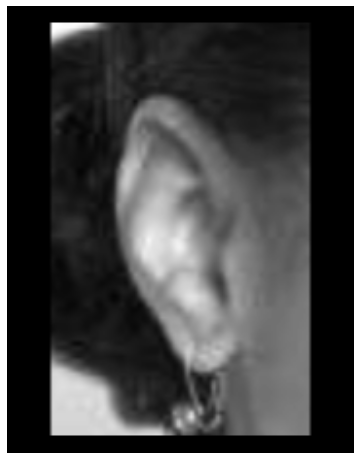

In [115]:
wimg.view()

In [116]:
data = zip(labels, nomask_data)

In [117]:
mio.export_pickle(data, '/homes/yz4009/wd/PickleModel/EarRecognition/LDA-VGG-Data-bbsift.pkl', overwrite=True)

### cordor setup

In [12]:
from workerbee import JobSet
import menpo.io as mio

In [13]:
jobname = 'cnn_patch_features'
# db_path = Path('/homes/yz4009/wd/databases/ear/VGGEers-Recognition')


In [23]:
js = JobSet(jobname,host='db.doc.ic.ac.uk',user='yz4009',password='1330871Pp',dbname='yz4009')
js.setup_jobset(ignore_existing_jobset=True)

INFO     (2016-09-12 13:27:58): Found Postgresql version 9.2.10 - Using JSON as the data type for the input_data field.
WARNING  (2016-09-12 13:27:58): NO UNIQUE constraint enforced - input_data field is of type JSON
INFO     (2016-09-12 13:27:58): Created table for jobset 'cnn_patch_features'


True

In [24]:
wd_path = '/vol/atlas/homes/yz4009'

In [25]:
str(frs[1].path).replace('/homes/yz4009/wd',wd_path)

'/vol/atlas/homes/yz4009/databases/ear/VGGEers-Recognition/Matt_Lauria/00000010_fr.pkl'

In [26]:
for fr in frs:
    i = fr.image
    i.landmarks['PTS'] = fr.final_shape
#     img_datas.append(cnn_feature(img_align(i)).ravel())
#     img_datas.append(cnn_patch_feature(i.rescale_to_diagonal(200).extract_patches_around_landmarks(group='PTS', patch_shape=(17,17))).ravel())
    js.add_jobs([{'path':str(fr.path).replace('/homes/yz4009/wd',wd_path)}])
    

INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12 13:28:08): Submitted 1 jobs
INFO     (2016-09-12

In [3]:
from dAAMs.tools import denseCNN, cnn_feature
from pathlib import Path
import menpo.io as mio
from menpo.image import Image
import numpy as np
from menpofit.aam import LucasKanadeAAMFitter


def cnn_patch_feature(patches):
    img_shape = patches.shape[2:]
    return np.array([cnn_feature(Image(pimg)) for pimg in patches.reshape((-1,)+img_shape)])


def func(args):
    
    
    fr_path = args['path']
    p = Path(fr_path)
    fr = mio.import_pickle(fr_path)
    
    img = fr.image
    img.landmarks['PTS'] = fr.final_shape
    
    feature = cnn_patch_feature(img.rescale_to_diagonal(200).extract_patches_around_landmarks(group='PTS', patch_shape=(17,17))).ravel()
    
    mio.export_pickle(feature, '{}/{}_cnn_patch.pkl'.format(p.parent, p.stem), overwrite=True)
    
    return

In [4]:
%%time
func({'path':'/vol/atlas/homes/yz4009/databases/ear/VGGEers-Recognition/Matt_Lauria/00000010_fr.pkl'})

CPU times: user 14min 37s, sys: 1min 43s, total: 16min 20s
Wall time: 4min 13s


### Deep Feature test

In [2]:
from dAAMs.tensorflowear import *

In [33]:
tf.reset_default_graph()

test_provider = EarDB(batch_size=64,db_name='VGGEAR', shape=(225,225), num_classes=500,root='/homes/yz4009/wd/PickleModel/EarRecognition/',is_training=False)
images, labels = test_provider.get('labels')

tf.image_summary('images', images)

predictions, layers = network(images, is_training=False, output_classes=500)

predictions = tf.to_int32(tf.argmax(predictions, 1))
labels = tf.to_int32(tf.argmax(labels, 1))

tf.scalar_summary('accuracy', slim.metrics.accuracy(predictions, labels))

num_batches = 859 // batch_size

sess = tf.Session()

# These are streaming metrics which compute the "running" metric,
# e.g running accuracy
metrics_to_values, metrics_to_updates = slim.metrics.aggregate_metric_map({
    "streaming_accuracy": slim.metrics.streaming_accuracy(predictions, labels),
})

# Define the streaming summaries to write:
for metric_name, metric_value in metrics_to_values.items():
    tf.scalar_summary(metric_name, metric_value)

global_step = slim.get_or_create_global_step()
variable_averages = tf.train.ExponentialMovingAverage(0.999, global_step)
variables_to_restore = variable_averages.variables_to_restore(slim.get_model_variables())


Found 2058 files.


In [34]:
from tensorflow.python.training import saver as tf_saver

In [35]:
output_layer = layers['resnet_v1_50/conv1']

In [36]:
output_layer.get_shape()

TensorShape([Dimension(64), Dimension(113), Dimension(113), Dimension(64)])

In [37]:
global_step = slim.get_or_create_global_step()

saver = tf_saver.Saver(slim.get_variables_to_restore())

In [38]:
checkpoint_dir = '/homes/yz4009/wd/gitdev/DenseHumanPose/dAAMs/ckpt/wputedb_train/'

In [39]:
checkpoint_path = tf_saver.latest_checkpoint(checkpoint_dir)

In [40]:
saver.restore(sess, checkpoint_path)

In [51]:
images

<tf.Tensor 'shuffle_batch:0' shape=(64, 225, 225, 3) dtype=float32>

In [52]:
output_layer.eval(feed_dict=[],session=sess)

TypeError: Using a `tf.Tensor` as a Python `bool` is not allowed. Use `if t is not None:` instead of `if t:` to test if a tensor is defined, and use the logical TensorFlow ops to test the value of a tensor.

In [48]:
layers

{'predictions': <tf.Tensor 'resnet_v1_50/predictions/Reshape_1:0' shape=(64, 1, 1, 500) dtype=float32>,
 'resnet_v1_50/block1': <tf.Tensor 'resnet_v1_50/block1/unit_3/bottleneck_v1/Relu:0' shape=(64, 29, 29, 256) dtype=float32>,
 'resnet_v1_50/block1/unit_1/bottleneck_v1': <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/Relu:0' shape=(64, 57, 57, 256) dtype=float32>,
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1': <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv1/Relu:0' shape=(64, 57, 57, 64) dtype=float32>,
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2': <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv2/Relu:0' shape=(64, 57, 57, 64) dtype=float32>,
 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3': <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/conv3/BatchNorm/batchnorm/add_1:0' shape=(64, 57, 57, 256) dtype=float32>,
 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut': <tf.Tensor 'resnet_v1_50/block1/unit_1/bottleneck_v1/shortcut/BatchNorm/batchn

In [49]:
predictions

<tf.Tensor 'ToInt32:0' shape=(64,) dtype=int32>

In [50]:
output_layer

<tf.Tensor 'resnet_v1_50/conv1/Relu:0' shape=(64, 113, 113, 64) dtype=float32>